In [7]:
# # Setup 
# ! pip install seaborn tqdm_joblib ndlib open-iris==1.0.0

# Imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
from joblib import Parallel, delayed
from tqdm import tqdm

In [9]:
n_jobs = 4 # Fit to CPU
DIM = (2, 32, 200)
X, Y = DIM [1:]

# Constants

In [10]:
conf_dict = {
    'no_mask':{
        'left':0.275,
        'right':0.047,
    },
    'h_len':{
        'left':{'mean':45, 'std':21, 'lower_lim':1, 'upper_lim':(Y//2)-1},
        'right':{'mean':77, 'std':17, 'lower_lim':1, 'upper_lim':(Y//2)-1},
    },
    'h_center':{
        'left':{'mean':51, 'std':15, 'lower_lim':1, 'upper_lim':(Y//2)-1},
        'right':{'mean':49, 'std':3.6, 'lower_lim':1, 'upper_lim':(Y//2)-1},
    },
    'v_len':{
        'left':{'mean':5.7, 'std':2.9, 'lower_lim':1, 'upper_lim':(X//2)-1},
        'right':{'mean':11.1, 'std':3.8, 'lower_lim':1, 'upper_lim':(X//2)-1},
    },    
}
true_mask = np.ones((X//2, Y//2), dtype=np.bool_)

# Functions

In [11]:
def plot_boolean_iris(matrix, title=''):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

In [12]:
def generate_normal_params(num_samples, mean, std, lower_lim, upper_lim):
    return np.clip(np.random.normal(loc=mean, scale=std, size=num_samples), lower_lim, upper_lim)[0]

In [13]:
def generate_mask_part(h_center, v_len, h_len):
    blob = np.zeros((X//2, Y//2))
    blob[(X//2)-1, round(h_center)] = 1
    sigma_x, sigma_y = (v_len / 3), (h_len / 6)
    blob = gaussian_filter(blob, sigma=[sigma_x, sigma_y])
    return blob <= blob.mean()

In [14]:
def generate_single_mask():
    left_params, right_params = (
        [generate_normal_params(num_samples=1, **conf_dict[part][side]) for part in ['h_center', 'v_len', 'h_len']] for side in ['left', 'right']
    )
    left_matrix, right_matrix = (generate_mask_part(*curr_params) for curr_params in [left_params, right_params])
    final_mask = np.hstack((left_matrix, right_matrix))
    return final_mask

In [15]:
def generate_single_mask(left_prob=conf_dict['no_mask']['left'], right_prob=conf_dict['no_mask']['right']):
    def get_matrix(prob, side):
        if np.random.rand() < prob:
            return true_mask
        params = [generate_normal_params(num_samples=1, **conf_dict[part][side]) for part in ['h_center', 'v_len', 'h_len']]
        return generate_mask_part(*params)
    
    left_matrix = get_matrix(left_prob, 'left')
    right_matrix = get_matrix(right_prob, 'right')
    return np.hstack((left_matrix, right_matrix))

In [16]:
def save_masks_arrays(masks_lst, filename):
    flattened_arrays = np.stack(masks_lst).reshape(-1)
    np.packbits(flattened_arrays).tofile(filename)

In [17]:
def load_and_reshape_masks(filename, num_masks):
    flattened_data = np.unpackbits(np.fromfile(filename, dtype=np.uint8))
    boolean_arrays = flattened_data.reshape((num_masks, X//2, Y))
    vertically_stacked = np.tile(boolean_arrays, (1, 2, 1))
    duplicated_arrays = np.repeat(vertically_stacked[:, np.newaxis, :, :], DIM[0], axis=1)
    return duplicated_arrays

# Generate and save Masks

In [18]:
def int_to_scaled_string(n):
    suffixes = ['', 'K', 'M', 'B', 'T']
    idx = max(0, min(len(suffixes) - 1, int((len(str(abs(n))) - 1) / 3)))
    scaled = n / (1000 ** idx)
    return f"{scaled:.1f}{suffixes[idx]}" if scaled % 1 else f"{int(scaled)}{suffixes[idx]}"

In [19]:
num_masks = 1000000
path = f'{int_to_scaled_string(num_masks)}_mask_arrays.dat'

In [21]:
with tqdm(total=num_masks, desc="Generating masks") as pbar:
    masks_lst = Parallel(n_jobs=n_jobs)(
        delayed(generate_single_mask)() for _ in range(num_masks)
    )
    pbar.update(1)

In [26]:
save_masks_arrays(masks_lst, path)

In [27]:
loaded_data = load_and_reshape_masks(path, num_masks)

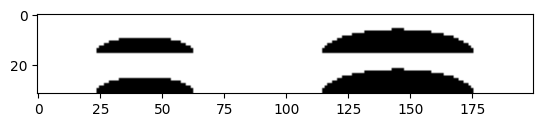

In [38]:
plot_boolean_iris(loaded_data[2][0])